# Half-life diversity of isoforms

This notebook profile the half-life diversity of isoforms.

In [1]:
from collections import defaultdict, Counter
import os
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from pyBioInfo.IO.File import GtfFile, GtfGeneBuilder, BedFile, BamFile
from pyBioInfo.Utils import BlockTools

## 1. Expressed isoforms of genes

--------------------------------------------------------------------------------
Cellline: K562
Genes expressed single isoform: 4240
Genes expressed multiple isoforms: 1071
0	3957	('protein_coding',)
1	575	('protein_coding', 'protein_coding')
2	164	('lncRNA',)
3	124	('protein_coding', 'protein_coding', 'protein_coding')
4	69	('processed_transcript', 'protein_coding')
5	64	('nonsense_mediated_decay', 'protein_coding')
6	56	('processed_transcript',)
7	54	('protein_coding', 'retained_intron')
8	30	('protein_coding', 'protein_coding', 'protein_coding', 'protein_coding')
9	22	('nonsense_mediated_decay', 'protein_coding', 'protein_coding')
--------------------------------------------------------------------------------
Cellline: mESC
Genes expressed single isoform: 5050
Genes expressed multiple isoforms: 573
0	4833	('protein_coding',)
1	348	('protein_coding', 'protein_coding')
2	84	('processed_pseudogene',)
3	54	('protein_coding', 'protein_coding', 'protein_coding')
4	52	('protein_coding', '

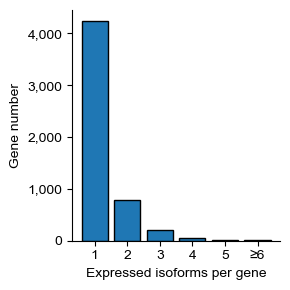

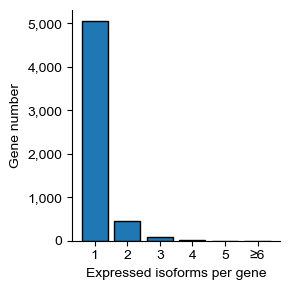

In [17]:
for cl in ["K562", "mESC"]:
    print("-" * 80)
    print("Cellline: %s" % cl)
    if cl == "K562":
        path = "../../1_FLAIRseq/reports/transcript_based/K562.all_cells.min_read_2_min_tc_2.annotated.tsv"
    else:
        path = "../../1_FLAIRseq/reports/transcript_based/mESC.all_cells.min_read_2_min_tc_2.annotated.tsv"
    df = pd.read_csv(path, sep="\t", index_col=0)
    df["Expressed"] = (df["TPM"] >= 10) & (df["Total"] >= 10)
    df = df[df["Total"] > 0]

    # output expressed isoform
    tmp = df[["Total", "TPM", "TranscriptType", "GeneID", "GeneType", "GeneName", "Chrom", "Start", "End", "Strand", "Expressed"]]
    tmp.to_csv("results/expression_of_isoform_%s.tsv" % cl, sep="\t")

    df = df[df["Expressed"]]
    data = dict()
    for gid, d in df.groupby(by="GeneID"):
        data[gid] = d

    # Expressed isoforms per gene
    counter = Counter([len(d) for d in data.values()])
    n1 = counter[1]
    n2 = sum(counter.values()) - n1
    print("Genes expressed single isoform: %d" % n1)
    print("Genes expressed multiple isoforms: %d" % n2)

    xs = [1, 2, 3, 4, 5, 6]
    ys = [counter[x] for x in xs]
    xticks = [str(x) for x in xs]
    ys[-1] = sum(counter.values()) - sum(ys[:-1])
    xticks[-1] = "≥%s" % xticks[-1]

    plt.figure(figsize=(3, 3))
    plt.bar(xs, ys, edgecolor="black")
    plt.xlabel("Expressed isoforms per gene")
    plt.ylabel("Gene number")
    plt.xticks(xs, xticks)
    ys1 = np.arange(0, plt.gca().get_ylim()[1] + 1, 1000)
    plt.yticks(ys1, [format(int(y), ",") for y in ys1])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/expressed_isoforms_per_gene.%s.pdf" % cl)

    # Transcript type of expressed 
    rows = []
    for gid, d in data.items():
        ss = []
        for k, v in sorted(Counter(d["TranscriptType"]).items()):
            ss.append("%s:%d" % (k, v))
        rows.append([gid, len(d), ";".join(ss)])
    d = pd.DataFrame(rows, columns=["GeneID", "TranscriptCount", "TranscriptTypes"])
    d.to_csv("results/expressed_transcript_type.%s.tsv" % cl, sep="\t", index=False)
    
    counter = Counter([tuple(list(sorted((d["TranscriptType"])))) for d in data.values()])
    items = list(sorted(counter.items(), key=lambda item: item[1], reverse=True))
    for i, (k, v) in enumerate(items[:10]):
        print(i, v, k, sep="\t")

--------------------------------------------------------------------------------
K562
Genes expressed multiple isoforms: 1071
0	3957	('protein_coding',)
1	575	('protein_coding', 'protein_coding')
2	164	('lncRNA',)
3	124	('protein_coding', 'protein_coding', 'protein_coding')
4	69	('processed_transcript', 'protein_coding')
5	64	('nonsense_mediated_decay', 'protein_coding')
6	56	('processed_transcript',)
7	54	('protein_coding', 'retained_intron')
8	30	('protein_coding', 'protein_coding', 'protein_coding', 'protein_coding')
9	22	('nonsense_mediated_decay', 'protein_coding', 'protein_coding')
--------------------------------------------------------------------------------
mESC
Genes expressed multiple isoforms: 573
0	4833	('protein_coding',)
1	348	('protein_coding', 'protein_coding')
2	84	('processed_pseudogene',)
3	54	('protein_coding', 'protein_coding', 'protein_coding')
4	52	('protein_coding', 'retained_intron')
5	36	('processed_transcript',)
6	35	('lincRNA',)
7	30	('processed_transcript

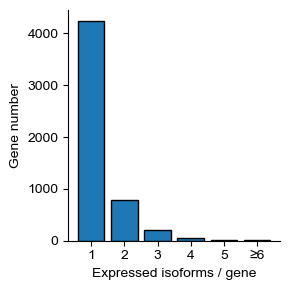

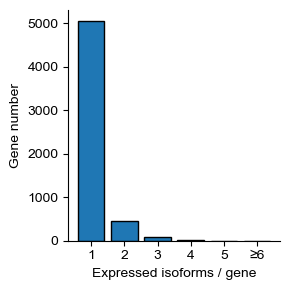

In [2]:
cell_lines = ["K562", "mESC"]

for cell_line in cell_lines:
    print("-" * 80)
    print(cell_line)
    if cell_line == "K562":
        df = pd.read_csv("../../1_FLAIRseq/reports/transcript_based/K562.all_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t", index_col=0)
    else:
        df = pd.read_csv("../../1_FLAIRseq/reports/transcript_based/mESC.all_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t", index_col=0)
    df = df[(df["TPM"] >= 10) & (df["Total"] >= 10)]
    counter = defaultdict(int)
    counter2 = defaultdict(int)
    for gid, tmp in df.groupby(by="GeneID"):
        counter[len(tmp)] += 1
        counter2[tuple(list(sorted((tmp["TranscriptType"]))))] += 1
    print("Genes expressed multiple isoforms: %d" % (sum(counter.values()) - counter[1]))
    xs = np.array([1, 2, 3, 4, 5, 6])
    ticks = list(map(str, xs))
    ticks[-1] = "≥%s" % ticks[-1]
    ys = np.array([counter[x] for x in xs])
    ys[-1] = sum(counter.values()) - sum(ys[:-1])
    plt.figure(figsize=(3, 3))
    plt.bar(xs, ys, edgecolor="black")
    plt.xlabel("Expressed isoforms / gene")
    plt.ylabel("Gene number")
    plt.xticks(xs, ticks)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/expressed_isoforms_per_gene.%s.pdf" % cell_line, dpi=300)
    
    items = list(sorted(counter2.items(), key=lambda item: item[1], reverse=True))
    for i, (k, v) in enumerate(items[:10]):
        print(i, v, k, sep="\t")

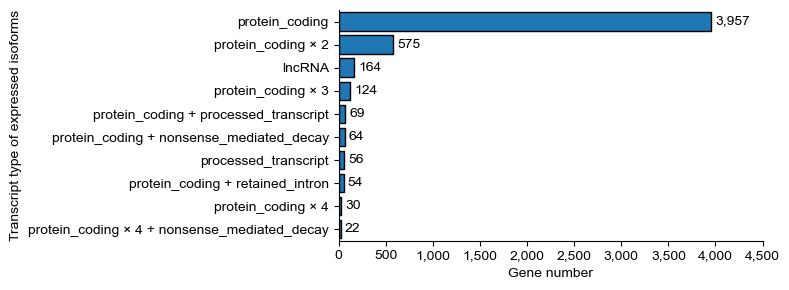

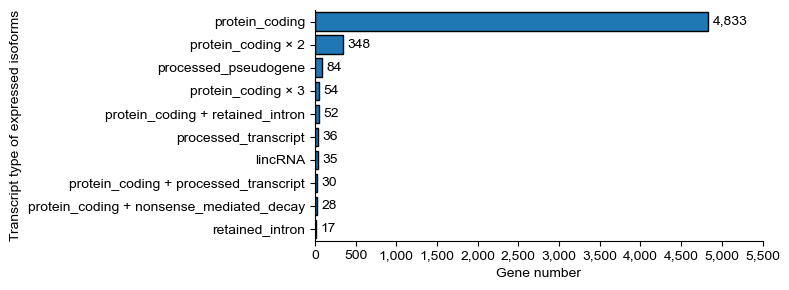

In [10]:
# K562
data1 = [
    [3957, "protein_coding"],
    [575, "protein_coding × 2"],
    [164, "lncRNA"],
    [124, "protein_coding × 3"],
    [69, "protein_coding + processed_transcript"],
    [64, "protein_coding + nonsense_mediated_decay"],
    [56, "processed_transcript"],
    [54, "protein_coding + retained_intron"],
    [30, "protein_coding × 4"],
    [22, "protein_coding × 4 + nonsense_mediated_decay"]
]

# mESC
data2 = [
    [4833, "protein_coding"],
    [348, "protein_coding × 2"],
    [84, "processed_pseudogene"],
    [54, "protein_coding × 3"],
    [52, "protein_coding + retained_intron"],
    [36, "processed_transcript"],
    [35, "lincRNA"],
    [30, "protein_coding + processed_transcript"],
    [28, "protein_coding + nonsense_mediated_decay"],
    [17, "retained_intron"]
]

for cell_line in ["K562", "mESC"]:
    if cell_line == "K562":
        data = data1
        lim = 4500
    else:
        data = data2
        lim = 5500
    ys = np.arange(len(data))
    xs = [v[0] for v in data]
    ticks = [v[1] for v in data]
    plt.figure(figsize=(8, 3))
    plt.barh(ys, xs, edgecolor="black")
    for x, y in zip(xs, ys):
        plt.text(x + lim * 0.01, y, "%s" % format(x, ","), va="center")
    plt.xlim(0, lim)
    plt.ylim(max(ys) + 0.5, min(ys) - 0.5)
    plt.xlabel("Gene number")
    plt.ylabel("Transcript type of expressed isoforms")
    plt.yticks(ys, ticks)
    xs1 = np.arange(0, lim + 1, 500)
    plt.xticks(xs1, [format(int(x), ",") for x in xs1])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/transcript_type_combination.%s.pdf" % cell_line)

## 2. Difference in NTR and half-life

In [2]:
def correct_halflife(time, ntrs, tmin, tmax):
    hts = []
    for ntr in ntrs:
        if ntr == 0:
            hts.append(tmax)
        elif ntr == 1:
            hts.append(tmin)
        else:
            ht = -time/np.log2(1-ntr)
            ht = max(min(ht, tmax), tmin)
            hts.append(ht)
    return hts

In [ ]:
for cl in ["K562", "mESC"]:
    rows = []
    path = "../../1_FLAIRseq/reports/transcript_based/%s.treatment_cells.min_read_2_min_tc_2.annotated.tsv" % cl
    df = pd.read_csv(path, sep="\t")
    df = df[df["Total"] > 0]
    rows = []
    for gid, tmp in df.groupby(by="GeneID"):
        tmp = tmp.sort_values(by="Total", ascending=False)
        for i in range(len(tmp)):
            s1 = tmp.iloc[i]
            tid1 = s1["TranscriptID"]
            ttype1 = s1["TranscriptType"]
            total1 = s1["Total"]
            nascent1 = s1["Nascent"]
            t1 = s1["T"]
            for j in range(len(tmp)):
                if i != j:
                    s2 = tmp.iloc[j]
                    tid2 = s2["TranscriptID"]
                    ttype2 = s2["TranscriptType"]
                    total2 = s2["Total"]
                    nascent2 = s2["Nascent"]
                    t2 = s2["T"]
                    pval = fisher_exact([[total1 - nascent1, nascent1], [total2 - nascent2, nascent2]])[1]
                    
                    row = [gid,
                           tid1, ttype1, total1, nascent1, nascent1/total1, t1,
                           tid2, ttype2, total2, nascent2, nascent2/total2, t2, 
                           pval]
                    rows.append(row)
            
    m = pd.DataFrame(rows, columns=["GeneID", 
                                    "TranscriptID1", "TranscriptType1", "Total1", "Nascent1", "NTR1", "T1",
                                    "TranscriptID2", "TranscriptType2", "Total2", "Nascent2", "NTR2", "T2", 
                                    "Pvalue"])
    m["Total.Min"] = m[["Total1", "Total2"]].min(axis=1)
    m["NTR.Diff"] = m["NTR2"] - m["NTR1"]
    m.to_csv("results/comparison_of_isoform_halflife.%s.tsv" % cl, sep="\t", index=False)
    
    # break

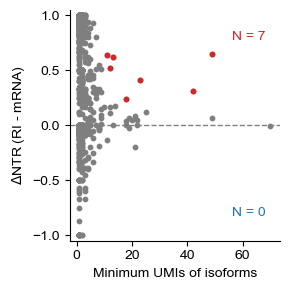

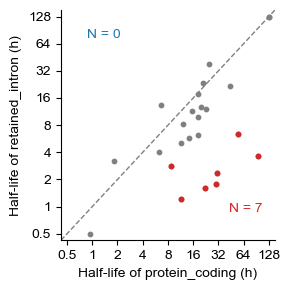

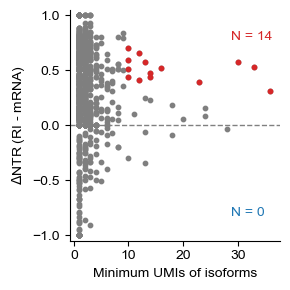

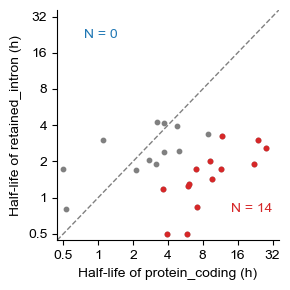

In [5]:
for cl in ["K562", "mESC"]:
    m = pd.read_csv("results/comparison_of_isoform_halflife.%s.tsv" % cl, sep="\t")
    m = m[(m["TranscriptType1"] == "protein_coding") & (m["TranscriptType2"] == "retained_intron")]
    # m = m[m["Total.Min"] >= 10]
    m = m[~m["GeneID"].duplicated()]

    # NTR
    m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
    m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
    xs, ys = m["Total.Min"], m["NTR.Diff"]
    xs1, ys1 = m1["Total.Min"], m1["NTR.Diff"]
    xs2, ys2 = m2["Total.Min"], m2["NTR.Diff"]
    plt.figure(figsize=(3, 3)) 
    s = 10
    plt.scatter(xs, ys, marker="o", s=s, color="C7", clip_on=False)
    plt.scatter(xs1, ys1, marker="o", s=s, color="C3", clip_on=False)
    plt.scatter(xs2, ys2, marker="o", s=s, color="C0", clip_on=False)
    plt.axhline(0, lw=1, ls="--", color="grey")
    plt.xlabel("Minimum UMIs of isoforms")
    plt.ylabel("$\Delta$NTR (RI - mRNA)")
    plt.ylim(-1.05, 1.05)
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    xmax = max(xs)
    plt.text(xmax * 0.8, 0.8, "N = %d" % len(xs1), color="C3", va="center")
    plt.text(xmax * 0.8, -0.8, "N = %d" % len(xs2), color="C0", va="center")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    # plt.savefig("figures/isoform_ntr_diff.mRNA_RI.%s.pdf" % cell_line)

    # Half-life
    if cl == "K562":
        x1, x2 = -1, 7
    else:
        x1, x2 = -1, 5
    w = x2 - x1
    m = m[m["Total.Min"] >= 10]
    m["T1"] = correct_halflife(3, m["NTR1"], 2**x1, 2**x2)
    m["T2"] = correct_halflife(3, m["NTR2"], 2**x1, 2**x2)
    m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
    m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
    # m1 = m[(m["T1"] > m["T2"]) & (m["Pvalue"] < 0.05)]
    # m2 = m[(m["T2"] > m["T1"]) & (m["Pvalue"] < 0.05)]
    if True:
        xs, ys = np.log2(m["T1"]), np.log2(m["T2"])
        xs1, ys1 = np.log2(m1["T1"]), np.log2(m1["T2"])
        xs2, ys2 = np.log2(m2["T1"]), np.log2(m2["T2"])
    else:
        xs, ys = m["T1"], m["T2"]
        xs1, ys1 = m1["T1"], m1["T2"]
        xs2, ys2 = m2["T1"], m2["T2"]
    s = 10
    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys, s=s, color="grey", clip_on=False)
    plt.scatter(xs1, ys1, s=s, color="C3", clip_on=False)
    plt.scatter(xs2, ys2, s=s,color="C0", clip_on=False)
    plt.text(x1 + w * 0.8, x1 + w * 0.1, "N = %d" % len(m1), color="C3")
    plt.text(x1 + w * 0.1, x1 + w * 0.9, "N = %d" % len(m2), color="C0")
    plt.plot([x1 - w * 0.03, x2 + w * 0.03], [x1 - w * 0.03, x2 + w * 0.03], lw=1, ls="--", color="grey")
    plt.xlim(x1 - w * 0.03, x2 + w * 0.03)
    plt.ylim(x1 - w * 0.03, x2 + w * 0.03)
    plt.xlabel("Half-life of protein_coding (h)")
    plt.ylabel("Half-life of retained_intron (h)")
    vs = np.arange(x1, x2 + 1)
    plt.xticks(vs, [2**int(v) for v in vs])
    plt.yticks(vs, [2**int(v) for v in vs])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/isoform_halflife_diff.mRNA_RI.%s.pdf" % cl)

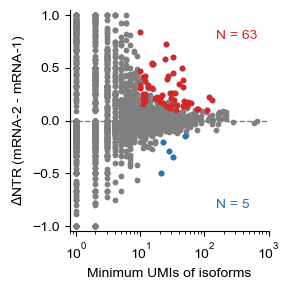

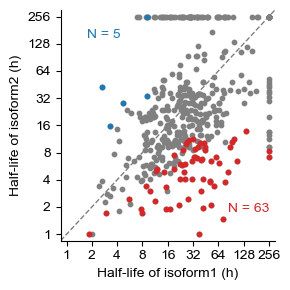

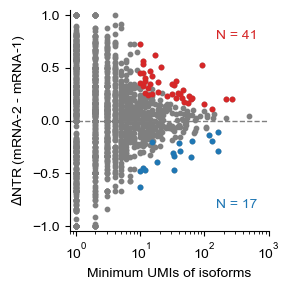

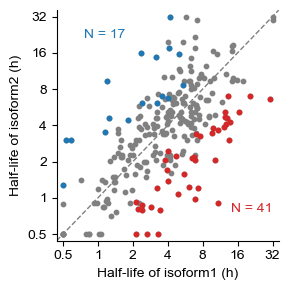

In [14]:
for cl in ["K562", "mESC"]:
    m = pd.read_csv("results/comparison_of_isoform_halflife.%s.tsv" % cl, sep="\t")
    m = m[(m["TranscriptType1"] == "protein_coding") & (m["TranscriptType2"] == "protein_coding")]
    m = m[m["Total1"] >= m["Total2"]]
    m = m[~m["GeneID"].duplicated()]

    m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
    m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
    xs, ys = m["Total.Min"], m["NTR.Diff"]
    xs1, ys1 = m1["Total.Min"], m1["NTR.Diff"]
    xs2, ys2 = m2["Total.Min"], m2["NTR.Diff"]
    plt.figure(figsize=(3, 3)) 
    s = 10
    plt.scatter(xs, ys, marker="o", s=s, color="C7", clip_on=False)
    plt.scatter(xs1, ys1, marker="o", s=s, color="C3", clip_on=False)
    plt.scatter(xs2, ys2, marker="o", s=s, color="C0", clip_on=False)
    plt.text(150, 0.8, "N = %d" % len(xs1), color="C3", va="center")
    plt.text(150, -0.8, "N = %d" % len(xs2), color="C0", va="center")
    plt.axhline(0, lw=1, ls="--", color="grey")
    plt.xlabel("Minimum UMIs of isoforms")
    plt.ylabel("$\Delta$NTR (mRNA-2 - mRNA-1)")
    plt.xscale("log")
    plt.xlim(0.8, 1000)
    plt.ylim(-1.05, 1.05)
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/isoform_ntr_diff.mRNA.%s.pdf" % cl)
    # plt.close()

    if cl == "K562":
        x1, x2 = 0, 8
    else:
        x1, x2 = -1, 5
    w = x2 - x1
    m = m[m["Total.Min"] >= 10]
    m["T1"] = correct_halflife(3, m["NTR1"], 2**x1, 2**x2)
    m["T2"] = correct_halflife(3, m["NTR2"], 2**x1, 2**x2)
    m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
    m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
    xs, ys = np.log2(m["T1"]), np.log2(m["T2"])
    xs1, ys1 = np.log2(m1["T1"]), np.log2(m1["T2"])
    xs2, ys2 = np.log2(m2["T1"]), np.log2(m2["T2"])
    s = 10
    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys, s=s, color="grey", clip_on=False)
    plt.scatter(xs1, ys1, s=s, color="C3", clip_on=False)
    plt.scatter(xs2, ys2, s=s,color="C0", clip_on=False)
    plt.text(x1 + w * 0.8, x1 + w * 0.1, "N = %d" % len(m1), color="C3")
    plt.text(x1 + w * 0.1, x1 + w * 0.9, "N = %d" % len(m2), color="C0")
    plt.plot([x1 - w * 0.03, x2 + w * 0.03], [x1 - w * 0.03, x2 + w * 0.03], lw=1, ls="--", color="grey")
    plt.xlim(x1 - w * 0.03, x2 + w * 0.03)
    plt.ylim(x1 - w * 0.03, x2 + w * 0.03)
    plt.xlabel("Half-life of isoform1 (h)")
    plt.ylabel("Half-life of isoform2 (h)")
    vs = np.arange(x1, x2 + 1)
    plt.xticks(vs, [2**int(v) for v in vs])
    plt.yticks(vs, [2**int(v) for v in vs])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/isoform_halflife_diff.mRNA.%s.pdf" % cl)

## 3. Decay rate diversity transcript model

In [16]:
d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
d = d[(d["CellLine"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
print("Cells:", len(d))
import pysam
import subprocess
bamfile1 = "results/FLAIRseq.K562.0uM3h.min_read_2.rmdup.bam"
bamfile2 = "results/FLAIRseq.K562.0uM3h.min_read_2.rmdup.sorted.bam"
if not os.path.exists(bamfile2):
    fw = None
    for run, cell in d[["Run", "Cell"]].values:
        path = "../../1_FLAIRseq/results/mapping/remove_duplicate/%s/%s.bam" % (run, cell)
        with pysam.AlignmentFile(path) as f:
            if fw is None:
                fw = pysam.AlignmentFile(bamfile1, "wb", f)
            for s in f:
                if s.get_tag("CS") >= 2 and not s.is_duplicate:
                    fw.write(s)
    fw.close()
    subprocess.check_call("samtools sort -@ 4 -o %s %s" % (bamfile2, bamfile1), shell=True)
    subprocess.check_call("samtools index -@ 4 %s" % bamfile2, shell=True)
    os.remove(bamfile1)

Cells: 190


In [19]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}

2253116 2268397
2252500 2269000 2500


[W::hts_idx_load3] The index file is older than the data file: ../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_0h_rep1.human.bam.bai


76048050 76067508
76047500 76068800 5000


[W::hts_idx_load3] The index file is older than the data file: ../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_0h_rep1.human.bam.bai


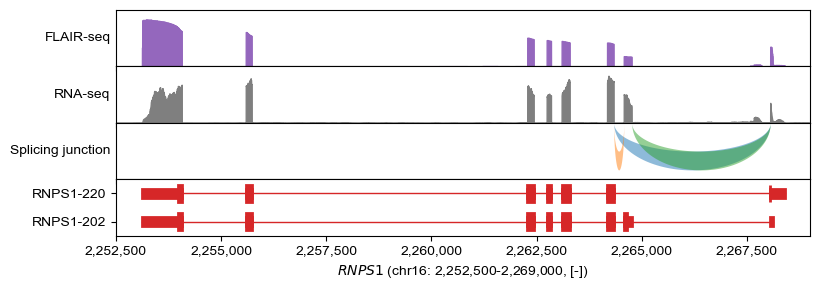

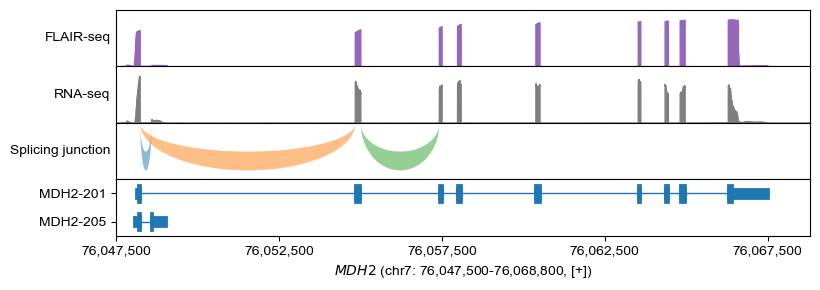

In [22]:
def get_coverages(path, chrom, start, end):
    covs = np.zeros(end - start)
    with BamFile(path, random=True) as f:
        for item in f.fetch(chrom, start, end):
            if item.segment.is_duplicate:
                continue
            for block_start, block_end in item.blocks:
                for idx in range(block_start - start, block_end - start):
                    if 0 <= idx < len(covs):
                        covs[idx] += 1  
    return covs

def plot_tracks(gname, tids, tnames, chrom, start, end, step, strand, junctions):
    bams = [
        "results/FLAIRseq.K562.0uM3h.min_read_2.rmdup.sorted.bam",
        "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_0h_rep1.human.bam"]
    covs_list = [get_coverages(path, chrom, start, end) for path in bams]
    
    if False:
        for covs in covs_list:
            plt.figure(figsize=(8, 2))
            xs = np.arange(start, end)
            plt.plot(xs, covs)
            plt.tight_layout()
            plt.show()
            plt.close()
        
    nrow = 4
    fig, axs = plt.subplots(nrow, 1, figsize=(8.3, 3), sharex=True, gridspec_kw={"hspace": 0})

    labels = ["FLAIR-seq", "RNA-seq"]
    colors = ["C4", "C7"]
    for i, covs in enumerate(covs_list[:2]):
        ax = axs[i]
        plt.sca(ax)
        xs = np.arange(start, end)
        ys = covs
        plt.fill_between(xs, ys, color=colors[i])
        plt.ylim(0, max(ys) * 1.2)
        plt.ylabel(labels[min(i, 1)], rotation=0, va="center", ha="right")
        plt.yticks([])

    ax = axs[nrow - 2]
    plt.sca(ax)
    plt.ylabel("Splicing junction", rotation=0, va="center", ha="right")
    plt.yticks([])
    plt.ylim(-0.6, 0)
    
    # plot splicing junction
    def get_ellipse_xy(s, e, b):
        center = (s + e) / 2
        a = (e - s) / 2
        a2 = a**2
        b2 = b**2
        c2 = a2 - b2
        xs = np.arange(s, e, 0.1)
        xs1 = xs - center
        x2 = xs1**2
        ys = (1 - x2 / a2) * b2
        ys = -np.power((1 - x2 / a2) * b2, 0.5)
        return xs, ys

    if True:
        for i, (s, e) in enumerate(junctions):
            xs1, ys1 = get_ellipse_xy(s, e, 0.3)
            xs2, ys2 = get_ellipse_xy(s, e, 0.5)
            plt.fill_between(xs1, ys1, ys2, alpha=0.5, lw=0, color="C%d" % i)

    ax = axs[nrow - 1]
    plt.sca(ax)
    exons = []
    cds = []
    color = "C0" if strand == "+" else "C3"
    for i, tid in enumerate(tids):
        y = -i
        transcript = transcripts[tid]
        # line
        length = transcript.end - transcript.start
        plt.plot([transcript.start, transcript.end], [y, y], lw=1, color=color)

        # exon
        for block_start, block_end in transcript.blocks:
            x = (block_start + block_end) / 2
            w = block_end - block_start # width
            h = 0.3 # height
            b = y - h / 2 # bottom
            exons.append([x, h, w, b])

        # cds
        if transcript.thick:
            thick_start, thick_end = transcript.thick
            for block_start, block_end in transcript.blocks:
                start1 = max(block_start, thick_start)
                end1 = min(block_end, thick_end)
                if start1 < end1:
                    x = (start1 + end1) / 2
                    w = end1 - start1
                    h = 0.6
                    b = y - h / 2
                    cds.append([x, h, w, b])
    
    # plot exons
    plt.bar([item[0] for item in exons], 
            [item[1] for item in exons], 
            width=[item[2] for item in exons], 
            bottom=[item[3] for item in exons], 
            edgecolor=color, lw=2,
            color=color)

    # plot cds
    plt.bar([item[0] for item in cds], 
            [item[1] for item in cds], 
            width=[item[2] for item in cds], 
            bottom=[item[3] for item in cds], 
            edgecolor=color, lw=2,
            color=color)

    plt.ylim(-1.5, 0.5)
    plt.yticks([0, -1], tnames)
    plt.xlim(start, end)
    xs = np.arange(start, end + 1, step)
    plt.xticks(xs, [format(x, ",") for x in xs])
    plt.xlabel("$\it{%s}$ (%s: %s-%s, [%s])" % (gname, chrom, format(start, ","), format(end, ","), strand))

    plt.tight_layout()
    plt.savefig("figures/gene_model.%s.pdf" % gname)
    
# RNPS1
gname = "RNPS1"
tids = ["ENST00000566458.5", "ENST00000320225.10"]
tnames = ["RNPS1-220", "RNPS1-202"]
chrom = transcripts[tids[0]].chrom
strand = "-"
min_start = min(transcripts[tids[0]].start, transcripts[tids[1]].start)
max_end = max(transcripts[tids[0]].end, transcripts[tids[1]].end)
print(min_start, max_end)
start, end = 2252500, 2269000
step = 2500
print(start, end, step)
junctions = [
    [2264331, 2268054],
    [2264331, 2264572],
    [2264760, 2268054]
]
plot_tracks(gname, tids, tnames, chrom, start, end, step, strand, junctions)

# MDH2
gname = "MDH2"
tids = ["ENST00000315758.10", "ENST00000461263.2"]
tnames = ["MDH2-201", "MDH2-205"]
chrom = transcripts[tids[0]].chrom
strand = "+"
min_start = min(transcripts[tids[0]].start, transcripts[tids[1]].start)
max_end = max(transcripts[tids[0]].end, transcripts[tids[1]].end)
print(min_start, max_end)
start, end = 76047500, 76068800
step = 5000
print(start, end, step)
junctions = [
    [76048226, 76048575],
    [76048226, 76054829],
    [76054998, 76057409]
]
plot_tracks(gname, tids, tnames, chrom, start, end, step, strand, junctions)

## 4. Validation of decay rate diversity by NGS

In [15]:
dat = pd.read_csv("../../4_RNAseq_ActD/reports/halflife_of_introns.tsv", sep="\t")
dat.index = ["%s:%s-%s" % (chrom, start, end) for chrom, start, end in dat[["Chrom", "Start", "End"]].values]

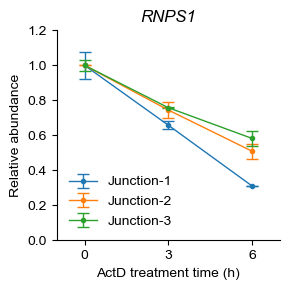

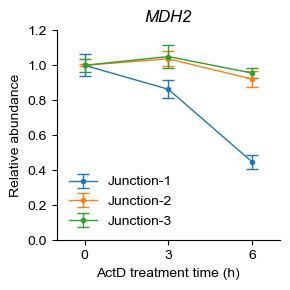

In [16]:
def plot_relative_abundance(gname, chrom, strand, introns, outfile=None):
    samples = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
    tmp = dat[dat['Strand'] == strand]
    d = tmp.loc[["%s:%s-%s" % (chrom, start, end) for start, end in introns]]
    d = d[["Abundance.%s" % s for s in samples]]
    labels = ["Junction-%d" % (i + 1) for i in range(len(d))] # MDH2
    colors = ["C0", "C1", "C2", "C3"]
    xs = [0, 0, 3, 3, 6, 6]
    plt.figure(figsize=(3, 3))
    plt.title(gname, style="italic")
    for i in range(len(d)):
        m = d.values[i].reshape(3, -1)
        ys1 = np.mean(m, axis=1)
        yerr1 = np.std(m, axis=1)
        xs1 = [0, 3, 6]
        plt.errorbar(xs1, ys1, yerr=yerr1, marker=".", label=labels[i], capsize=4, capthick=1, lw=1)
    # plt.text(0, 0.2, "$\it{%s}$" % gene_name)    
    plt.ylim(0, 1.2)
    plt.xlabel("ActD treatment time (h)")
    plt.ylabel("Relative abundance")
    plt.xticks([0, 3, 6])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.legend(frameon=False)
    plt.xlim(-1, 7)
    plt.tight_layout()
    plt.savefig("figures/validation_of_decay_by_ngs.%s.pdf" % gname)

plot_relative_abundance("RNPS1", "chr16", "-", [(2264331, 2268054), (2264331, 2264572), (2264760, 2268054)])
plot_relative_abundance("MDH2", "chr7", "+", [(76048226, 76048575), (76048226, 76054829), (76054998, 76057409)])

# Half-life diversity of isoforms

In [70]:
anno_g = pd.read_csv("/lustre/grp/tfclab/chenzg/species/homo_sapiens/GRCh38.p13/gencode.v39.genes.tsv", sep="\t", index_col=2)
del anno_g["TranscriptID"]
del anno_g["TranscriptType"]
anno_t = pd.read_csv("/lustre/grp/tfclab/chenzg/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t", index_col=0)
len(anno_g), len(anno_t)

(61533, 244939)

In [12]:
actd = pd.read_csv("../../4_RNAseq_ActD/results/introns/normalized_counts.20221128.tsv", sep="\t", index_col=0)
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
Ts = []
Ds = []
for vs in actd[[c + "_adj_p" for c in columns]].values:
    xs0 = [0, 0, 3, 3, 6, 6]
    ys0 = vs
    ys = ys0[2:]
    xs = np.array([3, 3, 6, 6])
    Y = np.log2(-np.log2(ys))
    X = np.log2(xs)
    b = sum(Y - X) / len(Y)
    T = 1 / (2 ** b)
    D = sum([abs(y - 2 ** (-x/T)) for x, y in zip(xs0, ys0)])
    Ts.append(T)
    Ds.append(D)
actd["T"] = Ts
actd["D"] = Ds

/lustre/grp/tfclab/chenzg/tmp/ipykernel_2425963/725802639.py:10: RuntimeWarning: invalid value encountered in log2
  Y = np.log2(-np.log2(ys))
/lustre/grp/tfclab/chenzg/tmp/ipykernel_2425963/725802639.py:10: RuntimeWarning: divide by zero encountered in log2
  Y = np.log2(-np.log2(ys))
/lustre/grp/tfclab/chenzg/tmp/ipykernel_2425963/725802639.py:14: RuntimeWarning: invalid value encountered in double_scalars
  D = sum([abs(y - 2 ** (-x/T)) for x, y in zip(xs0, ys0)])
/lustre/grp/tfclab/chenzg/tmp/ipykernel_2425963/725802639.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  D = sum([abs(y - 2 ** (-x/T)) for x, y in zip(xs0, ys0)])


In [1]:
with GtfFile("/lustre/grp/tfclab/chenzg/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.sorted.gtf.gz") as f:
    records = [x for x in f]
genes = list(GtfGeneBuilder(records))
gid2genes = {g.name: g for g in genes}

for g in genes:
    array = []
    for t in g.transcripts:
        introns = ["%s_%s_%s" % (t.chrom, x, y) for x, y in BlockTools.gaps(t.blocks)]
        s = pd.Series(1, index=introns, name=t.name)
        array.append(s)
    d = pd.DataFrame(array).fillna(0).T
    d.index.name = "Intron"
    g.intron_matrix = d

In [49]:
cs1 = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
cs2 = [
    "20221128_K562_Actd_0h_rep1", "20221128_K562_Actd_0h_rep2", 
    "20221128_K562_Actd_3h_rep1", "20221128_K562_Actd_3h_rep2", 
    "20221128_K562_Actd_6h_rep1", "20221128_K562_Actd_6h_rep2"]
array = []
for c1, c2 in zip(cs1, cs2):
    tmp = pd.read_csv("../../4_RNAseq_ActD/results/expression/fpkm/%s.human.rmdup.tsv" % c2, sep="\t", index_col=0)
    s = tmp["FPKM"]
    s.name = c1
    array.append(s)
fpkms_ngs = pd.concat(array, axis=1)

In [52]:
fpkm_tgs = pd.read_csv("../../1_NanoNASCseq/results/expression/report/isoform_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t", index_col=0)
fpkm_tgs.head()

,Total,Nascent,Total.Alleles,Nascent.Alleles,NTR,TPM,T,TranscriptType,GeneID,GeneType,GeneName,Chrom,Start,End,Strand,Canonical
TranscriptID,,,,,,,,,,,,,,,,
ENST00000000233.10,257,18,NaN,NaN,0.070039,558.715086,28.637502,protein_coding,ENSG00000004059.11,protein_coding,ARF5,chr7,127588410,127591700,+,True
ENST00000000412.8,14,4,NaN,NaN,0.285714,30.435841,6.180128,protein_coding,ENSG00000003056.8,protein_coding,M6PR,chr12,8940360,8949645,-,True
ENST00000000442.11,0,0,NaN,NaN,NaN,0.000000,NaN,protein_coding,ENSG00000173153.17,protein_coding,ESRRA,chr11,64305523,64316743,+,True
ENST00000001008.6,89,10,NaN,NaN,0.112360,193.484991,17.446660,protein_coding,ENSG00000004478.8,protein_coding,FKBP4,chr12,2794969,2805423,+,True
ENST00000002125.9,2,0,NaN,NaN,0.000000,4.347977,-inf,protein_coding,ENSG00000003509.16,protein_coding,NDUFAF7,chr2,37231657,37249160,+,True


In [75]:
rows = []
for gid, tmp in fpkm_tgs.groupby(by="GeneID"):
    tmp = tmp[(tmp["Total"] > 0) & (tmp["TranscriptType"] == "protein_coding")]
    if len(tmp) < 2:
        continue
    tmp = tmp.sort_values(by="Total", ascending=False)
    for i in range(0, len(tmp) - 1):
        for j in range(i + 1, len(tmp)):
            r1 = tmp.iloc[i]
            r2 = tmp.iloc[j]
            tid1, ttype1, total1, nascent1, t1 = r1.name, r1["TranscriptType"], r1["Total"], r1["Nascent"], r1["T"]
            tid2, ttype2, total2, nascent2, t2 = r2.name, r2["TranscriptType"], r2["Total"], r2["Nascent"], r2["T"]
            pval = fisher_exact([[total1 - nascent1, nascent1], [total2 - nascent2, nascent2]])[1]
            row = [gid,
                   tid1, ttype1, total1, nascent1, nascent1/total1, t1,
                   tid2, ttype2, total2, nascent2, nascent2/total2, t2, 
                   pval]
            rows.append(row)
            break
        break
m = pd.DataFrame(rows, columns=["GeneID", 
                                "TranscriptID1", "TranscriptType1", "Total1", "Nascent1", "NTR1", "T1",
                                "TranscriptID2", "TranscriptType2", "Total2", "Nascent2", "NTR2", "T2", 
                                "Pvalue"])
m["Total.Min"] = m[["Total1", "Total2"]].min(axis=1)
m["NTR.Diff"] = m["NTR2"] - m["NTR1"]
m.index = m["GeneID"]
del m["GeneID"]
m = m.merge(anno_g, left_index=True, right_index=True)

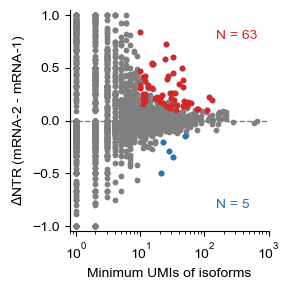

In [78]:
m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
xs, ys = m["Total.Min"], m["NTR.Diff"]
xs1, ys1 = m1["Total.Min"], m1["NTR.Diff"]
xs2, ys2 = m2["Total.Min"], m2["NTR.Diff"]

plt.figure(figsize=(3, 3)) 
s = 10
plt.scatter(xs, ys, marker="o", s=s, color="C7", clip_on=False)
plt.scatter(xs1, ys1, marker="o", s=s, color="C3", clip_on=False)
plt.scatter(xs2, ys2, marker="o", s=s, color="C0", clip_on=False)
plt.text(150, 0.8, "N = %d" % len(xs1), color="C3", va="center")
plt.text(150, -0.8, "N = %d" % len(xs2), color="C0", va="center")
plt.axhline(0, lw=1, ls="--", color="grey")
plt.xlabel("Minimum UMIs of isoforms")
plt.ylabel("$\Delta$NTR (mRNA-2 - mRNA-1)")
plt.xscale("log")
plt.xlim(0.8, 1000)
plt.ylim(-1.05, 1.05)
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
plt.close()

In [84]:
m[(m["GeneName"].isin(["RNPS1", "MDH2"]))]

,TranscriptID1,TranscriptType1,Total1,Nascent1,NTR1,T1,TranscriptID2,TranscriptType2,Total2,Nascent2,...,Total.Min,NTR.Diff,GeneType,GeneName,Chrom,Start,End,Strand,Canonical,Length
GeneID,,,,,,,,,,,,,,,,,,,,,
ENSG00000146701.12,ENST00000315758.10,protein_coding,687,33,0.048035,42.241941,ENST00000461263.2,protein_coding,32,21,...,32,0.608215,protein_coding,MDH2,chr7,76048105,76067508,+,True,19403
ENSG00000205937.12,ENST00000566458.5,protein_coding,24,13,0.541667,2.665409,ENST00000320225.10,protein_coding,21,1,...,21,-0.494048,protein_coding,RNPS1,chr16,2253119,2268126,-,True,15007


Total UMIs of higher isoforms: 43
Total UMIs of lower isoforms: 20
Introns of higher isoform:
[240, 271, 200, 231, 175, 176]
Introns of lower isoforms:
[112, 120, 117, 101, 92, 80]
[76, 74, 70, 64, 53, 47]


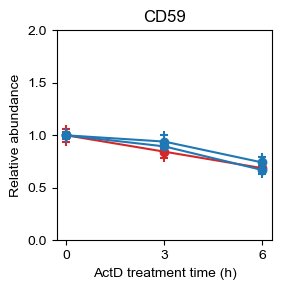

Total UMIs of higher isoforms: 290
Total UMIs of lower isoforms: 34
Introns of higher isoform:
[989, 889, 793, 798, 564, 526]
Introns of lower isoforms:
[121, 140, 92, 95, 59, 58]


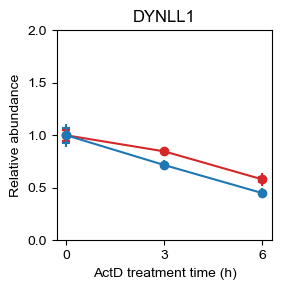

Total UMIs of higher isoforms: 83
Total UMIs of lower isoforms: 20
Introns of higher isoform:
[403, 407, 353, 316, 278, 286]
[368, 392, 319, 329, 265, 265]
Introns of lower isoforms:
[121, 100, 90, 92, 55, 46]


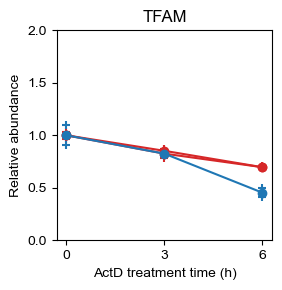

Total UMIs of higher isoforms: 45
Total UMIs of lower isoforms: 35
Introns of higher isoform:
[350, 301, 270, 272, 150, 150]
Introns of lower isoforms:
[346, 379, 279, 270, 120, 120]


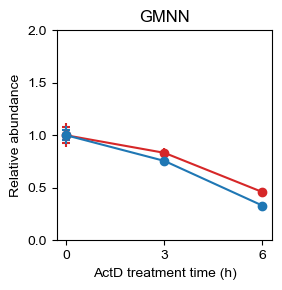

Total UMIs of higher isoforms: 109
Total UMIs of lower isoforms: 30
Introns of higher isoform:
[640, 663, 596, 655, 578, 558]
Introns of lower isoforms:
[174, 201, 178, 178, 125, 132]
[195, 199, 190, 197, 129, 137]


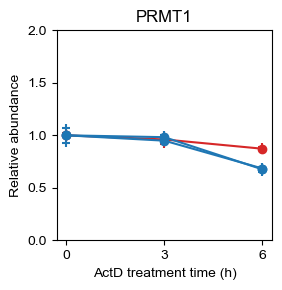

Total UMIs of higher isoforms: 1594
Total UMIs of lower isoforms: 32
Introns of higher isoform:
[6957, 6821, 6291, 6780, 5840, 5541]
[6817, 6639, 6313, 6757, 5885, 5602]
Introns of lower isoforms:
[108, 106, 107, 115, 111, 92]


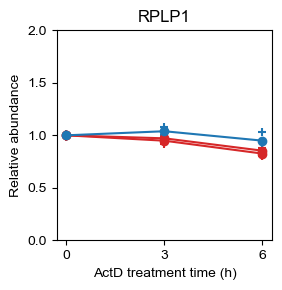

Total UMIs of higher isoforms: 687
Total UMIs of lower isoforms: 32
Introns of higher isoform:
[1993, 2020, 1996, 2161, 1945, 1752]
[1860, 2005, 1901, 2152, 1903, 1788]
Introns of lower isoforms:
[142, 161, 123, 139, 62, 75]


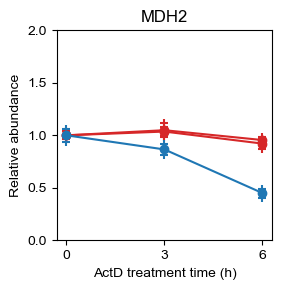

Total UMIs of higher isoforms: 284
Total UMIs of lower isoforms: 46
Introns of higher isoform:
[686, 784, 764, 755, 742, 719]
Introns of lower isoforms:
[109, 128, 105, 121, 94, 100]


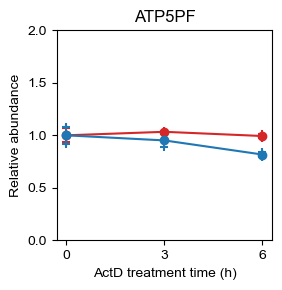

Total UMIs of higher isoforms: 65
Total UMIs of lower isoforms: 48
Introns of higher isoform:
[114, 123, 102, 121, 105, 118]
Introns of lower isoforms:
[186, 182, 219, 210, 189, 179]
[87, 75, 86, 81, 68, 81]


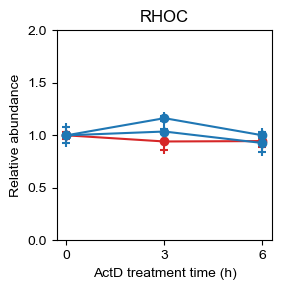

Total UMIs of higher isoforms: 133
Total UMIs of lower isoforms: 79
Introns of higher isoform:
[543, 521, 596, 581, 565, 554]
[576, 537, 600, 598, 574, 567]
Introns of lower isoforms:
[514, 524, 450, 492, 502, 451]


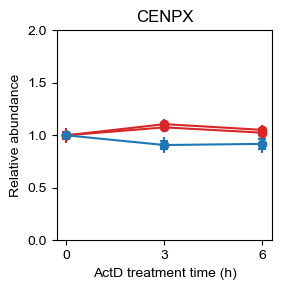

Total UMIs of higher isoforms: 214
Total UMIs of lower isoforms: 77
Introns of higher isoform:
[879, 843, 787, 823, 750, 704]
Introns of lower isoforms:
[253, 261, 233, 246, 168, 169]


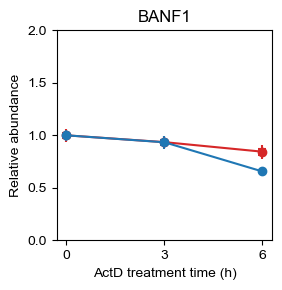

Total UMIs of higher isoforms: 1372
Total UMIs of lower isoforms: 54
Introns of higher isoform:
[6144, 6292, 5431, 5280, 4266, 4074]
[6448, 6555, 5540, 5617, 4482, 4354]
Introns of lower isoforms:
[133, 159, 139, 144, 124, 117]


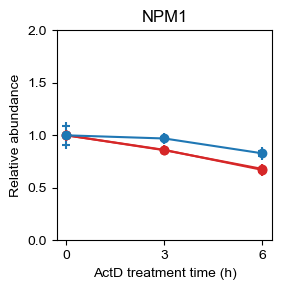

Total UMIs of higher isoforms: 48
Total UMIs of lower isoforms: 48
Introns of higher isoform:
[161, 183, 204, 178, 215, 200]
Introns of lower isoforms:
[161, 180, 211, 180, 199, 191]


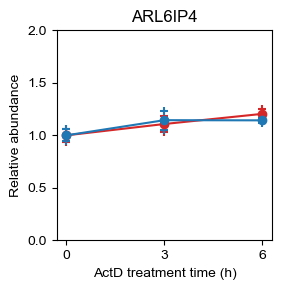

Total UMIs of higher isoforms: 590
Total UMIs of lower isoforms: 36
Introns of higher isoform:
[493, 530, 482, 485, 443, 416]
Introns of lower isoforms:
[272, 300, 320, 307, 278, 271]


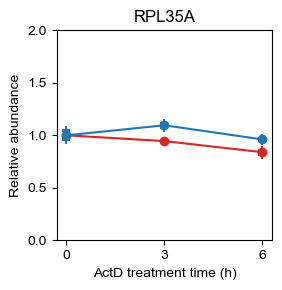

Total UMIs of higher isoforms: 2684
Total UMIs of lower isoforms: 54
Introns of higher isoform:
[1170, 1137, 1051, 1056, 926, 922]
Introns of lower isoforms:
[129, 114, 132, 127, 124, 112]


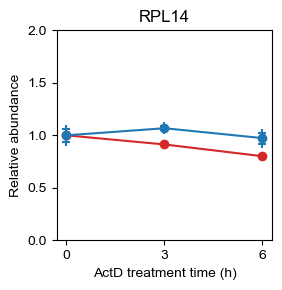

In [193]:
m3 = m1
# m3 = m2
for gid in m3.index:
    gene = gid2genes[gid]
    gname = m3.loc[gid]["GeneName"]
    # if gname != "MRPS24":
    #    continue
    # print(gid, gname)
    
    matrix = gene.intron_matrix
    tids = matrix.columns
    tids = tids[tids.isin(fpkm_tgs.index)]
    cutoff = max(5, list(sorted(fpkm_tgs.loc[tids]["Total"]))[-2] * 0.25)
    tids = tids[fpkm_tgs.loc[tids]["Total"] >= cutoff]
    # print(cutoff, len(tids))
    assert len(tids) >= 2
    matrix = matrix[tids]
    matrix = matrix[matrix.sum(axis=1) > 0]
    matrix = matrix[matrix.sum(axis=1) == 1]
    tid1, tid2 = m3.loc[gid]["TranscriptID1"], m3.loc[gid]["TranscriptID2"]
    s = m3.loc[gid]
    total1, total2 = s["Total1"], s["Total2"]
    introns1 = matrix[matrix[tid1] > 0].index
    introns2 = matrix[matrix[tid2] > 0].index

    v1 = 0
    for intron in introns1:
        v1 = max(v1, actd.loc[intron][["0h-1_adj", "0h-2_adj"]].max())
    v2 = 0
    for intron in introns2:
        v2 = max(v2, actd.loc[intron][["0h-1_adj", "0h-2_adj"]].max())
    if v1 < 100 or v2 < 100:
        continue
    
    if True:
        plt.figure(figsize=(3 ,3))
        plt.title(gname)
        print("Total UMIs of higher isoforms:", total1)
        print("Total UMIs of lower isoforms:", total2)
        
        print("Introns of higher isoform:")
        for intron in introns1:
            xs = [0, 0, 3, 3, 6, 6]
            ys = actd.loc[intron][["0h-1_adj_p", "0h-2_adj_p", "3h-1_adj_p", "3h-2_adj_p", "6h-1_adj_p", "6h-2_adj_p"]].values
            plt.scatter(xs, ys, marker="+", color="C3")
            xs1 = [0, 3, 6]
            ys1 = [np.mean(ys[0:2]), np.mean(ys[2:4]), np.mean(ys[4:6])]
            plt.plot(xs1, ys1, marker="o", color="C3")
            print(list(map(round, actd.loc[intron][["0h-1_adj", "0h-2_adj", "3h-1_adj", "3h-2_adj", "6h-1_adj", "6h-2_adj"]].values)))
        print("Introns of lower isoforms:")
        for intron in introns2:
            xs = [0, 0, 3, 3, 6, 6]
            ys = actd.loc[intron][["0h-1_adj_p", "0h-2_adj_p", "3h-1_adj_p", "3h-2_adj_p", "6h-1_adj_p", "6h-2_adj_p"]].values
            plt.scatter(xs, ys, marker="+", color="C0")
            xs1 = [0, 3, 6]
            ys1 = [np.mean(ys[0:2]), np.mean(ys[2:4]), np.mean(ys[4:6])]
            plt.plot(xs1, ys1, marker="o", color="C0")
            print(list(map(round, actd.loc[intron][["0h-1_adj", "0h-2_adj", "3h-1_adj", "3h-2_adj", "6h-1_adj", "6h-2_adj"]].values)))
        plt.xticks([0, 3, 6])
        plt.xlabel("ActD treatment time (h)")
        plt.ylim(0, 2)
        plt.ylabel("Relative abundance")
        plt.tight_layout()
        plt.show()
        plt.close()

In [218]:
gids = list(sorted(anno_g[anno_g["GeneType"] == "protein_coding"].index))

In [254]:
rows = []
for i, gid in enumerate(gids):
    if i % 100 == 0:
        print(i)
    gene = gid2genes[gid]
    matrix = gene.intron_matrix
    tmp = actd.loc[matrix.index]
    gene.intron_actd = tmp
    tmp = tmp[(tmp["0h-1_adj"] >= 100) & (tmp["0h-2_adj"] >= 100)]
    if len(tmp) >= 2:
        vs = tmp[["6h-1_adj_p", "6h-2_adj_p"]].mean(axis=1).values
        rows.append([gid, min(vs), max(vs)])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

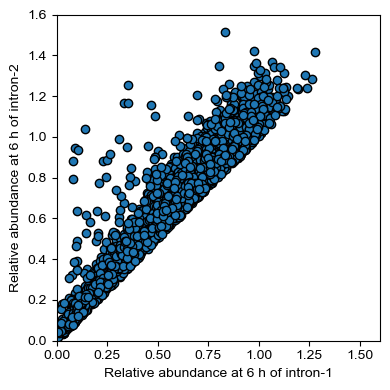

In [255]:
xs = np.array([row[1] for row in rows])
ys = np.array([row[2] for row in rows])
plt.figure(figsize=(4, 4))
plt.scatter(xs, ys, marker="o", color="C0", edgecolor="black")
plt.xlim(0, 1.6)
plt.ylim(0, 1.6)
plt.xlabel("Relative abundance at 6 h of intron-1")
plt.ylabel("Relative abundance at 6 h of intron-2")
plt.tight_layout()
plt.show()
plt.close()

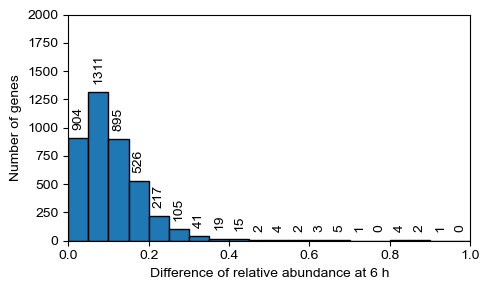

In [256]:
plt.figure(figsize=(5, 3))
ret = plt.hist(ys - xs, range=(0, 1), bins=20, edgecolor="black")
for x, y in zip(ret[1], ret[0]):
    plt.text(x + 0.01, y + 100, "%s" % int(y), rotation=90)
plt.xlim(0, 1)
plt.ylim(0, 2000)
plt.xlabel("Difference of relative abundance at 6 h")
plt.ylabel("Number of genes")
plt.tight_layout()
plt.show()

In [266]:
rows1 = []
for i, gid in enumerate(gids):
    if i % 100 == 0:
        print(i)
    gene = gid2genes[gid]
    matrix = gene.intron_matrix
    tmp = gene.intron_actd
    tmp = tmp[(tmp["0h-1_adj"] >= 100) & (tmp["0h-2_adj"] >= 100)]
    if len(tmp) >= 3:
        introns = [[start, end] for start, end in zip(tmp["Start"], tmp["End"])]
        introns = list(sorted(introns))
        for i in range(0, len(introns) - 2):
            for j in range(i + 1, len(introns) - 1):
                if introns[i][0] < introns[j][0]:
                    break
                assert introns[i][0] == introns[j][0]
                assert introns[i][1] < introns[j][1]
                for k in range(j + 1, len(introns)):
                    if introns[k][0] >= introns[j][1]:
                        break
                    if introns[k][0] > introns[i][1] and introns[k][1] == introns[j][1]:
                        # print(introns[i], introns[j], introns[k])
                        k1 = "%s_%s_%s" % (gene.chrom, introns[i][0], introns[i][1])
                        k2 = "%s_%s_%s" % (gene.chrom, introns[k][0], introns[k][1])
                        k3 = "%s_%s_%s" % (gene.chrom, introns[j][0], introns[j][1])
                        p1 = np.mean(tmp.loc[k1][["6h-1_adj_p", "6h-2_adj_p"]])
                        p2 = np.mean(tmp.loc[k2][["6h-1_adj_p", "6h-2_adj_p"]])
                        p3 = np.mean(tmp.loc[k3][["6h-1_adj_p", "6h-2_adj_p"]])
                        rows1.append([k1, k2, k3, p1, p2, p3])
        # break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [269]:
tmp = pd.DataFrame(rows1, columns=["Intron1", "Intron2", "Intron3", "P1", "P2", "P3"])
tmp.head()

,Intron1,Intron2,Intron3,P1,P2,P3
0,chr1_33014594_33021366,chr1_33021461_33021592,chr1_33014594_33021592,0.826525,0.828296,0.894145
1,chr1_23030634_23044426,chr1_23044486_23050386,chr1_23030634_23050386,0.652622,0.610973,0.638566
2,chr7_30498938_30500535,chr7_30500681_30504568,chr7_30498938_30504568,1.020926,1.038028,0.979314
3,chr17_32365487_32366664,chr17_32366757_32367771,chr17_32365487_32367771,0.417267,0.434878,0.316365
4,chr19_805187_805491,chr19_805569_806407,chr19_805187_806407,0.500887,0.492562,0.534418


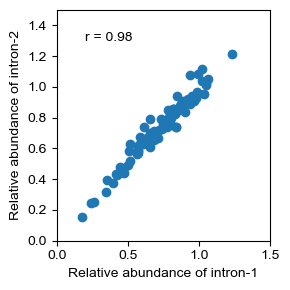

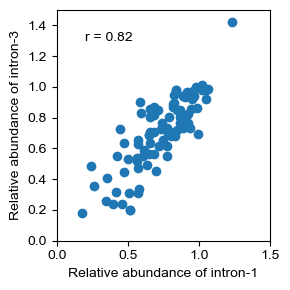

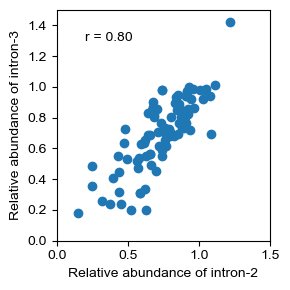

In [279]:
plt.figure(figsize=(3, 3))
plt.scatter(tmp["P1"], tmp["P2"])
r = np.corrcoef(tmp["P1"], tmp["P2"])[0][1]
plt.text(0.2, 1.3, "r = %.2f" % r)

plt.xlabel("Relative abundance of intron-1")
plt.ylabel("Relative abundance of intron-2")
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(3, 3))
plt.scatter(tmp["P1"], tmp["P3"])
r = np.corrcoef(tmp["P1"], tmp["P3"])[0][1]
plt.text(0.2, 1.3, "r = %.2f" % r)

plt.xlabel("Relative abundance of intron-1")
plt.ylabel("Relative abundance of intron-3")
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(3, 3))
plt.scatter(tmp["P2"], tmp["P3"])
r = np.corrcoef(tmp["P2"], tmp["P3"])[0][1]
plt.text(0.2, 1.3, "r = %.2f" % r)
plt.xlabel("Relative abundance of intron-2")
plt.ylabel("Relative abundance of intron-3")
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()
plt.close()